In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

c:\Users\Charlie Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_X = torch.load("train/train/trainX.pt")
train_Y = torch.load("train/train/trainY.pt")
test_X = torch.load("test/test/testX.pt")

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, Y = None):
        self.image = X[0]
        self.depth = X[1] / 1000
        self.id = X[2]
        self.y = Y[0] if Y != None else None

    
    def __getitem__(self, idx):
        image = self.image[idx][0]
        depth = self.depth[idx][0]
        y = self.y[idx] if self.y != None else torch.Tensor(0)


        image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).forward(image/225)
        depth = depth / 1000

        res_image = torch.cat((image, torch.tensor(np.expand_dims(depth, 0))), 0)

        return res_image.float(), y.float()

    def __len__(self):
        return self.image.shape[0]



In [4]:
dataset = CustomDataset(train_X, train_Y)
dataloader = DataLoader(dataset, 32, True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data image shape is torch.Size([32, 4, 224, 224])
Target shape is torch.Size([32, 12])


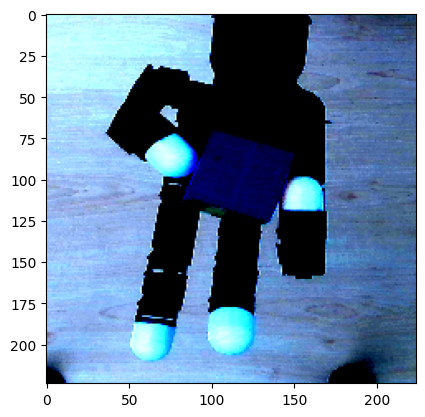

In [6]:
for i, (data, target) in enumerate(dataloader):
    x, y = data, target
    break

print("Data image shape is", x.shape)
print("Target shape is", y.shape)

img = x[0][:3,:,:].permute(1, 2, 0).squeeze()
plt.imshow(img)
plt.show()

In [7]:
def train(model, criterion, optimizer, scheduler, epoch):
    model.train()
    for idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            output = model(data)
            loss = torch.sqrt(criterion(output, target))

            loss.backward()
            optimizer.step()
        
        if idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, idx * len(data), len(dataloader.dataset),
                    100. * idx / len(dataloader), loss.item()
                ))

In [8]:
model = models.resnet50(weights="IMAGENET1K_V2")

model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, target.size(1))

model_ft = model.to(device)

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
for epoch in range(100):
    train(model, criterion, optimizer, scheduler, epoch)

Train Epoch: 0 [0/3396 (0%)]	Loss: 0.003081
Train Epoch: 0 [320/3396 (9%)]	Loss: 0.002657
Train Epoch: 0 [640/3396 (19%)]	Loss: 0.003088
Train Epoch: 0 [960/3396 (28%)]	Loss: 0.003143
Train Epoch: 0 [1280/3396 (37%)]	Loss: 0.002815
Train Epoch: 0 [1600/3396 (47%)]	Loss: 0.002916
Train Epoch: 0 [1920/3396 (56%)]	Loss: 0.002837
Train Epoch: 0 [2240/3396 (65%)]	Loss: 0.002956
Train Epoch: 0 [2560/3396 (75%)]	Loss: 0.002830
Train Epoch: 0 [2880/3396 (84%)]	Loss: 0.003208
Train Epoch: 0 [3200/3396 (93%)]	Loss: 0.002924
Train Epoch: 1 [0/3396 (0%)]	Loss: 0.003055
Train Epoch: 1 [320/3396 (9%)]	Loss: 0.003031
Train Epoch: 1 [640/3396 (19%)]	Loss: 0.002947
Train Epoch: 1 [960/3396 (28%)]	Loss: 0.003009
Train Epoch: 1 [1280/3396 (37%)]	Loss: 0.002911
Train Epoch: 1 [1600/3396 (47%)]	Loss: 0.002973
Train Epoch: 1 [1920/3396 (56%)]	Loss: 0.002793
Train Epoch: 1 [2240/3396 (65%)]	Loss: 0.002821
Train Epoch: 1 [2560/3396 (75%)]	Loss: 0.002925
Train Epoch: 1 [2880/3396 (84%)]	Loss: 0.003468
Train Ep

In [28]:
torch.save(model.state_dict(), 'model406.pt')

In [29]:
file_ids = test_X[-1]

test = CustomDataset(test_X)

model_ft.eval()
preds = []
for data, target in test:
    data= data.to(device)
    outputs = model(data.unsqueeze(0))
    preds.append(outputs[0].cpu().detach().numpy())

In [30]:
outfile = 'submission406.csv'
ourput_file = open(outfile, 'w')

titles = ['ID',
 'FINGER_POS_1',
 'FINGER_POS_2',
 'FINGER_POS_3',
 'FINGER_POS_4',
 'FINGER_POS_5',
 'FINGER_POS_6',
 'FINGER_POS_7',
 'FINGER_POS_8',
 'FINGER_POS_9',
 'FINGER_POS_10',
 'FINGER_POS_11',
 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print('done')

done
